In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from re import L
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [4]:
df = pd.read_excel('G:\My Drive\Drilling\Drilling_Data.xls')
df.head()

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105 entries, 0 to 4104
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MD                        4105 non-null   object 
 1   ROP                       4105 non-null   object 
 2   ROP.1                     4105 non-null   object 
 3   WOB                       4105 non-null   object 
 4   WOB.1                     4105 non-null   object 
 5   BIT_RPM                   4105 non-null   object 
 6   TRQ                       4105 non-null   object 
 7   SPP                       4105 non-null   object 
 8   Flow In                   4105 non-null   object 
 9   SPM                       4105 non-null   object 
 10  MWI                       4105 non-null   object 
 11  MWO                       4105 non-null   object 
 12  Actpitv                   4105 non-null   object 
 13  HOOKLOAD                  4105 non-null   object 
 14  CSIP    

In [31]:
df = df.drop(
    ['MD', 'WOB', 'TRQ', 'SPP', 'Flow In', 'SPM', 'Actpitv', 'HOOKLOAD', 'CSIP',
     'P ovb For Soft formation', 'P ovb For Hard formation', 'P ovb', 'd',
     'D adjust', 'PP Eaton Method'], axis=1
)
df = df.drop(0, axis=0)
df = df.reset_index(drop=True)
df.head()

,ROP,ROP.1,WOB.1,BIT_RPM,MWI,MWO,PP Zamora Method
0,19.586777,0.051055,2.337192,50,64.518444,65.143444,8.586818
1,10.84991,0.092167,1.141016,50,64.587152,65.212152,8.586906
2,4.559271,0.219333,1.066446,50,64.555458,65.180458,8.586865
3,4.231312,0.236333,0.894834,50,64.574378,65.199378,8.58689
4,3.367003,0.297,0.726287,50,64.586844,65.211844,8.586905


In [32]:
numeric_columns = ['ROP', 'ROP.1', 'WOB.1', 'BIT_RPM', 'MWI', 'MWO',
                   'PP Zamora Method']

for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4104 entries, 0 to 4103
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ROP               4104 non-null   float64
 1   ROP.1             4104 non-null   float64
 2   WOB.1             4104 non-null   float64
 3   BIT_RPM           4104 non-null   float64
 4   MWI               4104 non-null   float64
 5   MWO               4104 non-null   float64
 6   PP Zamora Method  4104 non-null   float64
dtypes: float64(7)
memory usage: 224.6 KB


In [34]:
print(df.isnull().sum())

ROP                 0
ROP.1               0
WOB.1               0
BIT_RPM             0
MWI                 0
MWO                 0
PP Zamora Method    0
dtype: int64


In [35]:
X = df.drop('PP Zamora Method', axis=1)
y = df['PP Zamora Method']

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error , r2_score

# Compute the Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, y_pred)

# Compute RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

r2 = r2_score(Y_test, y_pred)

# Print R²
print(f"R²: {r2}")

RMSE: 0.009990037212837883
R²: 0.990309052513296


In [39]:
# Evaluate performance on training data
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_train_pred))
train_r2 = r2_score(Y_train, y_train_pred)

# Evaluate performance on test data
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))
test_r2 = r2_score(Y_test, y_test_pred)

# Print out the metrics
print(f"Training RMSE: {train_rmse}")
print(f"Training R²: {train_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

Training RMSE: 0.010572632598550027
Training R²: 0.9883502655567481
Test RMSE: 0.009990037212837883
Test R²: 0.990309052513296


In [40]:
residuals = Y_test - y_pred

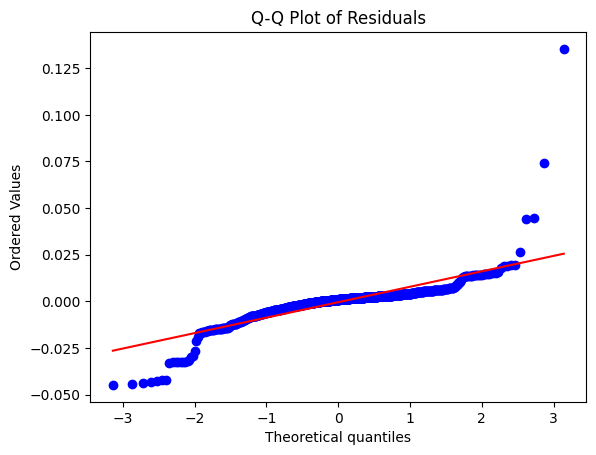

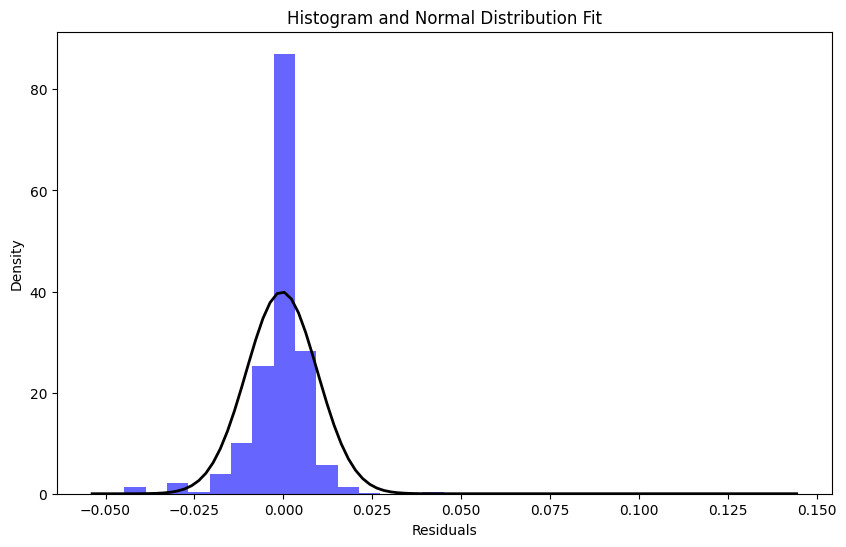

In [41]:

# Assuming you have already calculated the residuals as 'residuals'
if isinstance(residuals, (np.ndarray, pd.Series)):
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    # Histogram of Residuals with Normal Distribution Overlay
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='b')

    # Overlay a normal distribution curve for comparison
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, residuals.mean(), residuals.std())
    plt.plot(x, p, 'k', linewidth=2)

    plt.title('Histogram and Normal Distribution Fit')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.show()
else:
    print("The 'residuals' variable is not defined or does not contain a valid array or series.")

In [1]:
def predict_new_input(model, input_data):
    
    if isinstance(input_data, list):
        input_data = np.array(input_data).reshape(1, -1)
    
    prediction = model.predict(input_data)

    return prediction


